In [143]:
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 


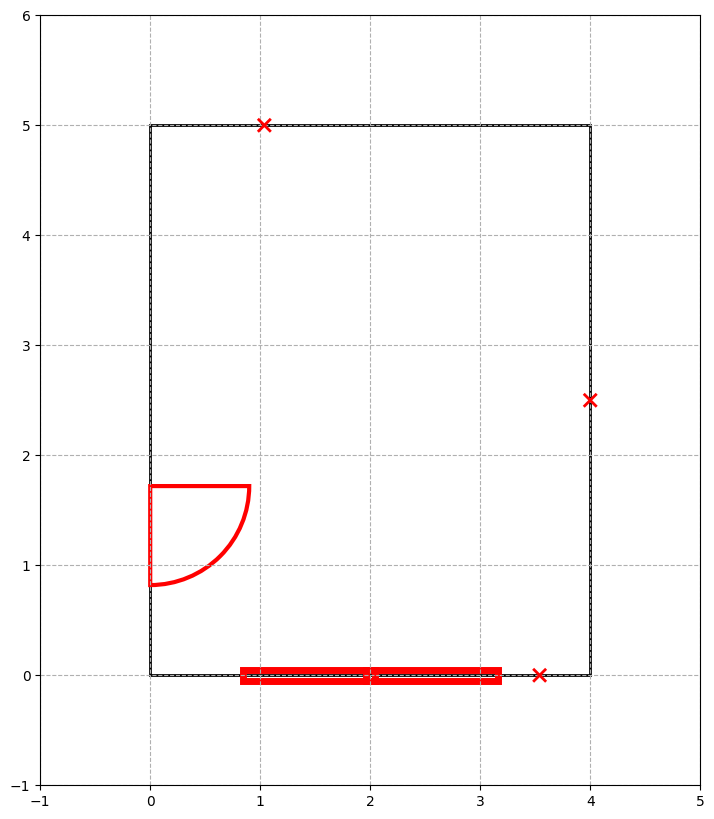

In [83]:
room = create_room(4, 5)
create_fixed_object(room, 'window', 1.2, 0.1, 'south', 0.3)
create_fixed_object(room, 'window', 1.2, 0.1, 'south', 0.7)
create_fixed_object(room, 'door', 0.9, 0.1, 'west', 0.2)
create_fixed_object(room, 'socket', 0.15, 0.1, 'north', 0.25)
create_fixed_object(room, 'socket', 0.15, 0.1, 'east', 0.5)
create_fixed_object(room, 'socket', 0.15, 0.1, 'south', 0.9)

region_setup(room, 'sleeping', 0)
region_setup(room, 'storage', 1)
region_setup(room, 'workspace', 2)

room.draw()

In [84]:
create_moving_object(room, 'bed', 1.6, 2.0, 'sleeping', 0)
create_moving_object(room, 'wardrobe', 1.8, 0.6, 'storage', 1)
create_moving_object(room, 'desk', 1.2, 0.6, 'workspace', 2)

In [85]:
def optimize_primary_objects(positions, room):
    output = 0
    output  += ind_next_to_wall(positions, room, 0)
    output  += ind_next_to_wall(positions, room, 1)
    output  += ind_next_to_wall(positions, room, 2)

    output  += ind_accessible(positions, room, 0, ['left'])
    output  += ind_away_from_fixed_object(positions, room, 0, 'window')
    output  += ind_close_to_fixed_object(positions, room, 0, 'socket')
    output  += ind_accessible(positions, room, 0, ['front'])
    output  += ind_not_block_fixed_object(positions, room, 1, 'window')
    output  += ind_not_block_fixed_object(positions, room, 1, 'door')
    output  += ind_close_to_fixed_object(positions, room, 1, 'socket')
    output  += ind_close_to_fixed_object(positions, room, 2, 'socket')
    output  += ind_not_block_fixed_object(positions, room, 2, 'window')
    output  += io_away_from(positions, room, 0, 2)
    output  += io_away_from(positions, room, 1, 0)
    output  += io_away_from(positions, room, 1, 2)
    output  += io_away_from(positions, room, 2, 1)
    output  += io_away_from(positions, room, 0, 1)

    output += wall_attraction(positions, room)
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    output += 10*balanced(positions, room)
    return output

Iteration: 10 , New best result found. Cost:  9.528257010756978
Iteration: 25 , New best result found. Cost:  7.3358508423137225
Iteration: 151 , New best result found. Cost:  6.6134539340600345
Iteration: 300 , New best result found. Cost:  6.277506892631393


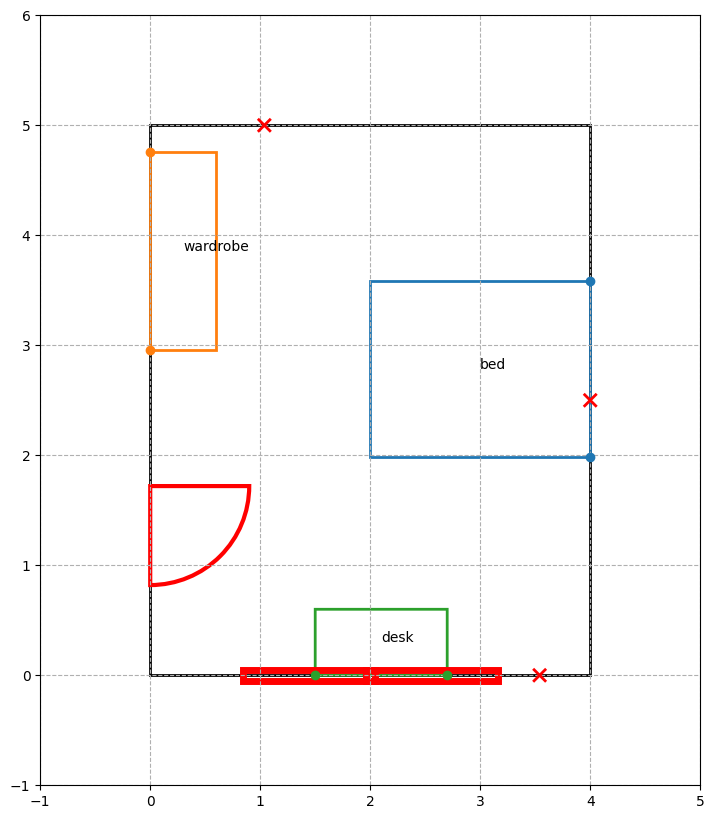

In [87]:
options = {'maxiter': 300, 'ftol': 1e-6}
iters = 0
min_fun = np.Inf
while iters < 300:
    positions = np.zeros((len(room.moving_objects) - len(room.fm_indices)) * 3)
    for i in range(len(room.moving_objects) - len(room.fm_indices)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.3 and not in_bounds(res.x, room) > 1e-2:
            min_fun = res.fun
            best_res = res
            print("Iteration:", iters, ", New best result found. Cost: ", min_fun)

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    j = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
room.draw() 

for i in range(3):
    room.regions[i].x, room.regions[i].y = room.moving_objects[i].position[0], room.moving_objects[i].position[1]


In [212]:
def io_next_to(positions, room, object1_index, object2_index, side1 = None, side2 = None):
    """ The function next_to ensures that two objects are next to each other in a room. 
        This function should only be used when two objects need to be next to each other, 
        e.g. a chair next to a desk, a bed next to a nightstand, a sofa next to side table. 

        Args:
        room: rectangular Room object
        object1: Object object
        object2: Object object
        side1: optional string, one of 'top' or 'back', 'bottom' or 'front', 'left', 'right', defines which side of object1 to use
        side2: optional string, one of 'top' or 'back', 'bottom' or 'front', 'left', 'right', defines which side of object2 to use
    """
    val = 0

    obj1 = room.moving_objects[object1_index]
    obj2 = room.moving_objects[object2_index]

    x1, y1, theta1 = get_position(positions, room, object1_index)
    x2, y2, theta2 = get_position(positions, room, object2_index)

    cs1 = np.array(corners(x1, y1, theta1, obj1.width, obj1.length)) # TL, TR, BR, BL
    cs2 = np.array(corners(x2, y2, theta2, obj2.width, obj2.length)) # TL, TR, BR, BL

    if side1: 
        if side1 == 'top' or side1 == 'back':
            point1, point2 = cs1[0], cs1[1] # TL, TR
        elif side1 == 'bottom' or side1 == 'front':
            point1, point2 = cs1[2], cs1[3] # BR, BL
        elif side1 == 'left':
            point1, point2 = cs1[0], cs1[3] # TL, BL
        elif side1 == 'right':
            point1, point2 = cs1[1], cs1[2] # TR, BR
        else:
            return io_next_to(positions, room, object1_index, object2_index, side2 = side2)
    if side2: 
        if side2 == 'top' or side2 == 'back':
            point3, point4 = cs2[0], cs2[1]
        elif side2 == 'bottom' or side2 == 'front':
            point3, point4 = cs2[2], cs2[3]
        elif side2 == 'left':
            point3, point4 = cs2[0], cs2[3]
        elif side2 == 'right':
            point3, point4 = cs2[1], cs2[2]
        else:
            return io_next_to(positions, room, object1_index, object2_index, side1 = side1)
        
    if side1 and side2:

        ### if two sides are given, we want the two sides to be parallel, as well as the two objects to be close to each other
        ### Want it to not matter if the centers are close per se, more that the sides are close (perpendicular distance between the two lines?)
        direction1 = np.array([point2[0] - point1[0], point2[1] - point1[1]]) # side1
        direction2 = np.array([point4[0] - point3[0], point4[1] - point3[1]]) # side2

        angle_diff = np.arccos(np.dot(direction1, direction2)/(max(np.linalg.norm(direction1), 1e-6)*max(np.linalg.norm(direction2), 1e-6)))
        val += 2 * np.sin(angle_diff)**2

        if np.linalg.norm(direction1) > np.linalg.norm(direction2):
            point5 = np.array([(point3[0] + point4[0]) / 2, (point3[1] + point4[1]) / 2]) # point on the shorter side
            point6 = np.array([(point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2]) # point on the longer side
            dim_shorter = np.linalg.norm(direction2)
            direction3 = np.array([point5[0] - point1[0], point5[1] - point1[1]])
            direction4 = np.array([point5[0] - point2[0], point5[1] - point2[1]])
            t = np.dot(direction1, direction3)/np.linalg.norm(direction1)
            direction5 = direction1
        else: 
            point5 = np.array([(point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2]) # point on the shorter side
            point6 = np.array([(point3[0] + point4[0]) / 2, (point3[1] + point4[1]) / 2]) # point on the longer side
            dim_shorter = np.linalg.norm(direction1)
            direction3 = np.array([point5[0] - point3[0], point5[1] - point3[1]])
            direction4 = np.array([point5[0] - point4[0], point5[1] - point4[1]])
            t = np.dot(direction2, direction3)/np.linalg.norm(direction2)
            direction5 = direction2
        if t < 0: 
            val += np.linalg.norm(direction3)**2 + (t)**2 + (point5[0] - point6[0])**2 + (point5[1] - point6[1])**2
        elif t > 1: 
            val += np.linalg.norm(direction4)**2 + (t - 1)**2 + (point5[0] - point6[0])**2 + (point5[1] - point6[1])**2
        else: 
            val += (point5[0] - point6[0])**2 + (point5[1] - point6[1])**2
        if np.linalg.norm(t*direction5) < dim_shorter/2: 
            val += 10*(dim_shorter/2 - np.linalg.norm(t*direction5))**2
        if np.linalg.norm((1 - t)*direction5) < dim_shorter/2:
            val += 10*(dim_shorter/2 - np.linalg.norm((1 - t)*direction5))**2
        else: 
            distance = np.linalg.norm(np.cross(direction5, direction3)) / np.linalg.norm(direction5)
            val += distance**2
    
    if side1 and not side2:
        min_side_dist = np.inf
        sides = ['front', 'back', 'left', 'right']
        for i in range(4): 
            side_value = io_next_to(positions, room, object1_index, object2_index, side1 = side1, side2 = sides[i])
            min_side_dist = min(min_side_dist, side_value)
        val += min_side_dist
                
        return val 
    
    if side2 and not side1:     
        min_side_dist = np.inf
        sides = ['front', 'back', 'left', 'right']
        for i in range(4): 
            side_value = io_next_to(positions, room, object1_index, object2_index, side1 = sides[i], side2 = side2)
            min_side_dist = min(min_side_dist, side_value)
        val += min_side_dist

        return val 
    if not side2 and not side1: 
        ### If no sides are given, we want the two objects to be close to each other as possible from any direction
        ### Want the distance between the two objects to be minimized but also to not be overlapping 

        distance = np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))
        val += distance**2

    return 2*val 

In [213]:
#room.moving_objects += [Object('desk', 1.2, 0.6, 'workspace', 2)]
room.moving_objects[-1].position = best_res.x[6:9]

In [216]:
room.moving_objects = room.moving_objects[:-1]
print(room.moving_objects)

[<Class_Structures.Object object at 0x146fa33a0>, <Class_Structures.Object object at 0x146fa3580>, <Class_Structures.Object object at 0x147134910>]


Iteration 1 , New best result found. Cost:  1.6950079291466886 overlap:  9.482317425046273e-06 bounds:  3.0690015376768886e-13
Iteration 2 , New best result found. Cost:  1.1249307979427834 overlap:  0.01860283952324812 bounds:  3.0690015376768886e-13
Iteration 4 , New best result found. Cost:  1.1249286929448823 overlap:  0.018288087398045397 bounds:  3.0690015376768886e-13
Iteration 13 , New best result found. Cost:  1.1249286209006533 overlap:  0.018172415238637583 bounds:  3.0690015376768886e-13
Iteration 33 , New best result found. Cost:  1.1249285360785664 overlap:  0.01828201767163478 bounds:  3.0690015376768886e-13
Iteration 59 , New best result found. Cost:  1.1249284938837922 overlap:  0.01825986854381857 bounds:  3.0690015376768886e-13
100


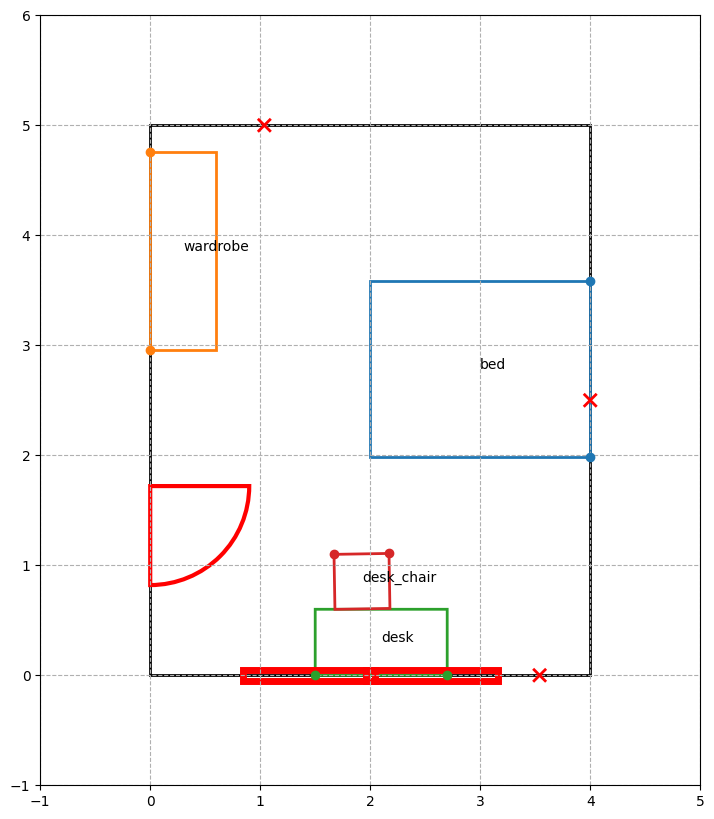

In [217]:
# create_moving_object(room, 'nightstand', 0.5, 0.5, 'sleeping', 3)
# create_moving_object(room, 'nightstand', 0.5, 0.5, 'sleeping', 4)
options = {'maxiter': 300, 'ftol': 1e-6}
create_moving_object(room, 'desk_chair', 0.5, 0.5, 'workspace', 3)
from scipy.optimize import minimize, Bounds, NonlinearConstraint
def optimize_secondary_objects(positions, room):
    output = 0
    output  += ind_accessible(positions, room, 0, ['left'])
    output += ind_accessible(positions, room, 2, ['front'])
    output  += io_next_to(positions, room, 3, 2, 'front', 'front')
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    return output 

room.fm_indices = [0, 1, 2]
num = len(room.moving_objects) - len(room.fm_indices)
bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
best_res2 = None
while (min_fun > 1e-2 and best_res2 is None and iters < 350) or (best_res2 and iters < min(num*100, 300)):
    if iters == 349: 
        print("Iteration 150, no solution found, putting the objects outside of the room.")
        best_res2 = res
        best_res2.x = np.array([room.width + 3, room.length + 3, 0] * num)
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.1:
            min_fun = res.fun 
            best_res2 = res
            print("Iteration", iters, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))

print(iters)
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    j = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res2.x[3*j:3*j + 3] 
    
room.draw() 




In [193]:
def ind_accessible(positions, room, object_index, sides = [], min_dist = None):
    """ This function ensures that an object is accessible from given sides. 
        If no sides are given, all the sides will be used. If min_dist is given, then this function 
        will act as a clearance constraint. If you want all the sides to be accesible, sides = ['top', 'bottom', 'left', 'right'].
    
        Args:
        positions: list of floats, x, y, theta values for all objects in the room
        room: rectangular Room object
        object_index: int, index of the object in the room's object list
        sides: a list of strings, each one one of 'top' or 'back', 'bottom' or 'front', 'left', 'right', defines which side of the object to check
        min_dist: float, minimum distance of clearance there should be on the sides. 
    """
    
    val = 0.0 # initialise output value 

    obj = room.moving_objects[object_index]
    rug_names = ['rug', 'mat', 'Rug', 'Mat', 'RUG', 'MAT', 'carpet', 'Carpet']
    for i in range(len(rug_names)): 
        if rug_names[i] in obj.name:
            return 0.0
    
    x, y, theta = get_position(positions, room, object_index)
    TL, TR, BR, BL = corners(x, y, theta, obj.width, obj.length)
    polys = []
    if min_dist: 
        distance = min_dist
    else: 
        distance = min(1, np.max([obj.width, obj.length, 0.5]))

    def project(point1, point2, distance = distance):
        direction = np.array([point1[0] - point2[0], point1[1] - point2[1]])
        direction /= np.linalg.norm(direction)
        return [point1[0], point1[1]] + distance * direction
    
    def wall_bounds(point):
        if point[0] < 0 or point[0] > room.width or point[1] < 0 or point[1] > room.length:
            return min(0.0, point[0])**2 + min(0.0, point[1])**2 + max(0.0, point[0] - room.width)**2 + max(0.0, point[1] - room.length)**2
        return 0.0
    
    if sides == []: 
        sides = ['front']

    if sides == ['sides']: 
        sides = ['left', 'right']
    
    for i in range(len(sides)): 

        if sides[i] == 'long':
            if obj.width > obj.length:
                val = np.random.randn()
                if val > 0: 
                    sides[i] = 'left'
                else: 
                    sides[i] = 'right'
            else: 
                sides[i] = 'front'
        elif sides[i] == 'short':
            if obj.width > obj.length:
                sides[i] = 'front'
            else: 
                sides[i] = 'left'
        
    for side in sides: 
        if side == 'top' or side == 'back':
            new_pointL = project(TL, BL)
            new_pointR = project(TR, BR)
            if nan_check([new_pointL, new_pointR]):
                continue
            polys += [Polygon([TL, TR, new_pointR, new_pointL])]
            val += wall_bounds(new_pointL) + wall_bounds(new_pointR)
        elif side == 'bottom' or side == 'front':
            new_pointL = project(BL, TL) 
            new_pointR = project(BR, TR)
            if nan_check([new_pointL, new_pointR]):
                continue
            polys += [Polygon([new_pointL, new_pointR, BR, BL])]
            val += wall_bounds(new_pointL) + wall_bounds(new_pointR)
        elif side == 'left':
            new_pointT = project(TL, TR)
            new_pointB = project(BL, BR)
            if nan_check([new_pointT, new_pointB]):
                continue
            polys += [Polygon([TL, new_pointT, new_pointB, BL])]
            val += wall_bounds(new_pointT) + wall_bounds(new_pointB)
        elif side == 'right':
            new_pointT = project(TR, TL)
            new_pointB = project(BR, BL)
            if nan_check([new_pointT, new_pointB]):
                continue
            polys += [Polygon([new_pointT, TR, BR, new_pointB])]
            val += wall_bounds(new_pointT) + wall_bounds(new_pointB)
        else: 
            ## If no side is given or a side is incorrect, assume accessible from the front 
            return ind_accessible(positions, room, object_index, ['front'])
    
    for poly in polys:
        for i in range(len(room.moving_objects)):
            if i == object_index:
                continue

            rug = 0
            for name in rug_names: 
                if name in room.moving_objects[i].name:
                    rug = 1
                    continue
            if rug == 1:
                continue

            x, y, theta = get_position(positions, room, i)
            poly2 = Polygon(corners(x, y, theta, room.moving_objects[i].width, room.moving_objects[i].length))
            intersection = poly.intersection(poly2)
            if intersection.area > 1e-3:
                x = np.array([[i, j] for i, j in zip(intersection.exterior.xy[0], intersection.exterior.xy[1])])
                lengths = np.roll(x, -1, axis = 0) - x
                lengths = np.linalg.norm(lengths, axis = 1)
                val += sum(lengths**2)   

        for i in range(len(room.fixed_objects)):
            if room.fixed_objects[i].name != 'door':
                continue
            else: 
                poly2 = Polygon(room.fixed_objects[i].corners())
                intersection = poly.intersection(poly2)
                if intersection.area > 1e-3:
                    x = np.array([[i, j] for i, j in zip(intersection.exterior.xy[0], intersection.exterior.xy[1])])
                    lengths = np.roll(x, -1, axis = 0) - x
                    lengths = np.linalg.norm(lengths, axis = 1)
                    val += 5*sum(lengths**2)

    return val

In [69]:
desk_chair = room.find('desk_chair')
positions = np.zeros(3*len(room.moving_objects))
for i in range(len(room.moving_objects)):
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]

print(io_next_to(positions, room, 2, 3, 'front', 'front'))
print(ind_accessible(positions, room, 0, ['left']), ind_accessible(positions, room, 2, ['front']),io_next_to(positions, room, 3, 2, 'front', 'front'),  in_bounds(positions, room), no_overlap(positions, room), aligned(positions, room))

11.46816165346213
0.0 0.0002405385851508064 11.46816165346213 0.004731238311476349 4.9999999999999964 4.230181217322479e-07


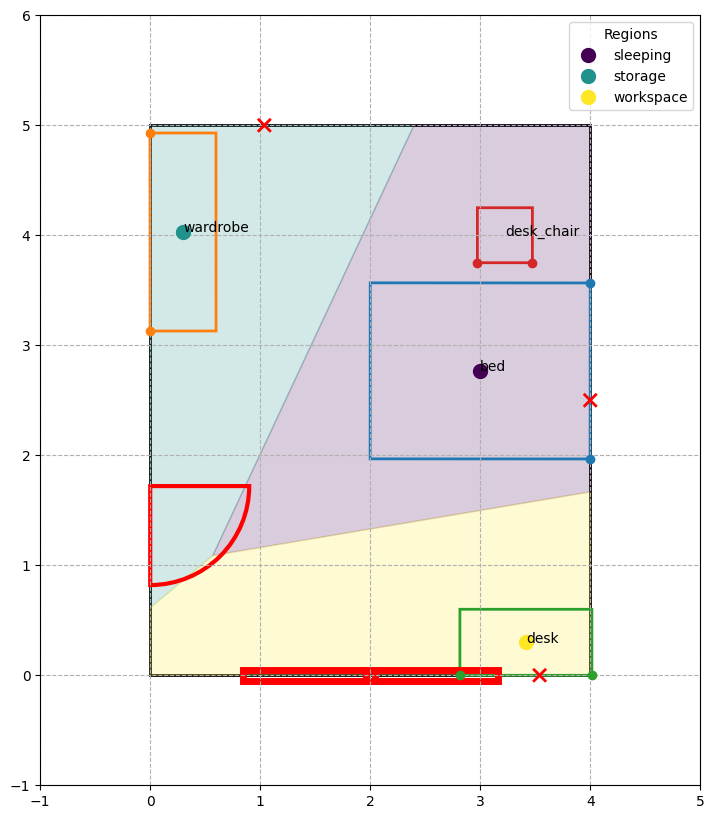

In [36]:
room.draw(draw_regions = True)